# **Read Data**

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

data_array = np.load('/content/drive/MyDrive/GP-Data/data_array.npy')
label_array = np.load('/content/drive/MyDrive/GP-Data/label_array.npy')
group_array = np.load('/content/drive/MyDrive/GP-Data/group_array.npy')

print(data_array.shape,label_array.shape,group_array.shape)

(7150, 1250, 33) (7150,) (7150,)


In [4]:
gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)


def three_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      train_features, train_label = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      train_features=scaler.fit_transform(train_features)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  # Split train_features into train and val
  for train_index, val_index in gkf.split(train_features, train_label, groups= train_groups):
      X_train, y_train =train_features[train_index],train_label[train_index]
      X_val, y_val =train_features[val_index],train_label[val_index]

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[val_index])}")

      break

  return X_train, X_val, X_test, y_train, y_val, y_test




def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test


# X_train, X_val, X_test, y_train, y_val, y_test = three_splits(data_array , label_array, group_array)

X_train, X_test, y_train, y_test = two_splits(data_array , label_array, group_array)

# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one

y_train[y_train==0] = 1
y_train[y_train==2] = 0

# y_val[y_val==0] = 1
# y_val[y_val==2] = 0

y_test[y_test==0] = 1
y_test[y_test==2] = 0

group=[ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 18 19 20 22 23 25 27 28 29
 30 31 34 36 37 38 39 40 41 42 43 44 45 46 47]
group=[ 9 14 17 21 24 26 32 33 35]


In [5]:
# Reshape data for compatibility with classifiers
re_Xtrain = X_train.reshape(X_train.shape[0], -1)
# re_Xval = X_val.reshape(X_val.shape[0], -1)
re_Xtest = X_test.reshape(X_test.shape[0], -1)

# **RF hyper, trail and error**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Creating the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=9,max_leaf_nodes=6 )

# Training the model
rf_model.fit(re_Xtrain, y_train)

# Making predictions
y_pred = rf_model.predict(re_Xtest)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.7744034707158352
Precision: 0.8302654684433426
Recall: 0.7744034707158352
F1 Score: 0.7272723585027164


True Positives: 948
True Negatives: 123
False Positives: 312
False Negatives: 0


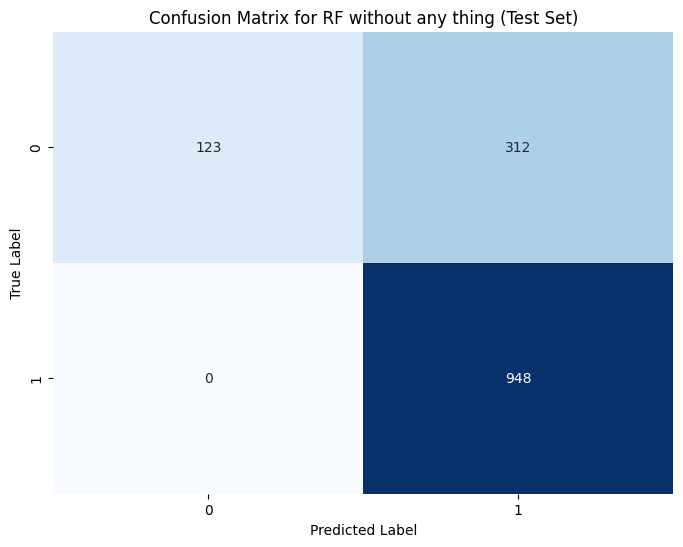

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for RF without any thing (Test Set)")
plt.show()

In [ ]:
import joblib

# Save the trained model and feature selection step
joblib.dump(rf_model, '/content/drive/MyDrive/GP-Trail/RF_model_hyper.pkl')
# joblib.dump(feature_selection, '/content/drive/MyDrive/GP-Trail/feature_selection


['/content/drive/MyDrive/GP-Trail/RF_model_hyper.pkl']

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# param_grid = {'n_estimators': [25, 50, 100, 150],
#               'max_depth': [3, 6, 9,11],
#               'max_leaf_nodes': [3, 6, 9,11]}


# Creating the Random Forest model
rf_model = RandomForestClassifier(n_estimators=25, max_depth=9,max_leaf_nodes=6 )

# Training the model
rf_model.fit(re_Xtrain, y_train)

# Making predictions
y_pred = rf_model.predict(re_Xtest)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.5018076644974693
Precision: 0.459609182810777
Recall: 0.5018076644974693
F1 Score: 0.47863510519610997


True Positives: 660
True Negatives: 34
False Positives: 401
False Negatives: 288


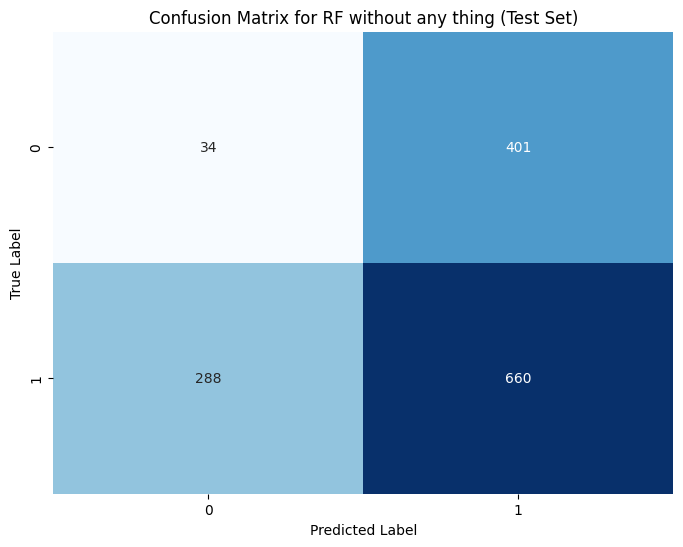

In [7]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for RF without any thing (Test Set)")
plt.show()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# param_grid = {'n_estimators': [25, 50, 100, 150],
#               'max_depth': [3, 6, 9,11],
#               'max_leaf_nodes': [3, 6, 9,11]}


# Creating the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=9,max_leaf_nodes=6 )

# Training the model
rf_model.fit(re_Xtrain, y_train)

# Making predictions
y_pred = rf_model.predict(re_Xtest)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6840202458423716
Precision: 0.4695519138729677
Recall: 0.6840202458423716
F1 Score: 0.5568494573280964


True Positives: 946
True Negatives: 0
False Positives: 435
False Negatives: 2


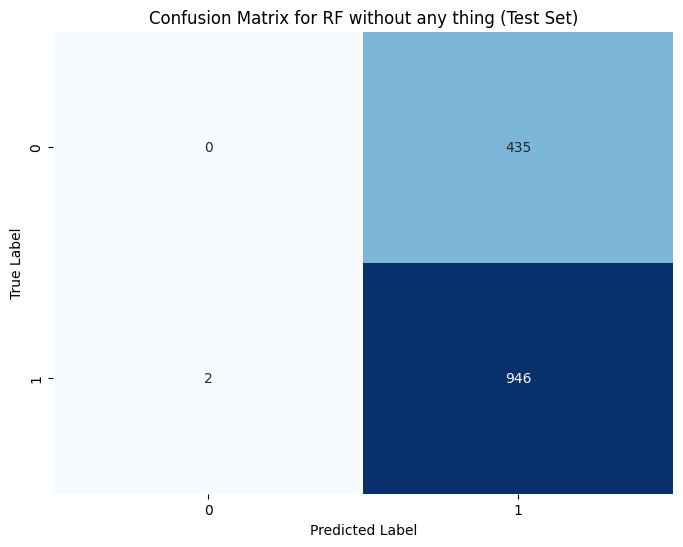

In [9]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for RF without any thing (Test Set)")
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# param_grid = {'n_estimators': [25, 50, 100, 150],
#               'max_depth': [3, 6, 9,11],
#               'max_leaf_nodes': [3, 6, 9,11]}


# Creating the Random Forest model
rf_model = RandomForestClassifier(n_estimators=150, max_depth=9,max_leaf_nodes=6 )

# Training the model
rf_model.fit(re_Xtrain, y_train)

# Making predictions
y_pred = rf_model.predict(re_Xtest)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6854663774403471
Precision: 0.46986415460119235
Recall: 0.6854663774403471
F1 Score: 0.5575479414958807


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


True Positives: 948
True Negatives: 0
False Positives: 435
False Negatives: 0


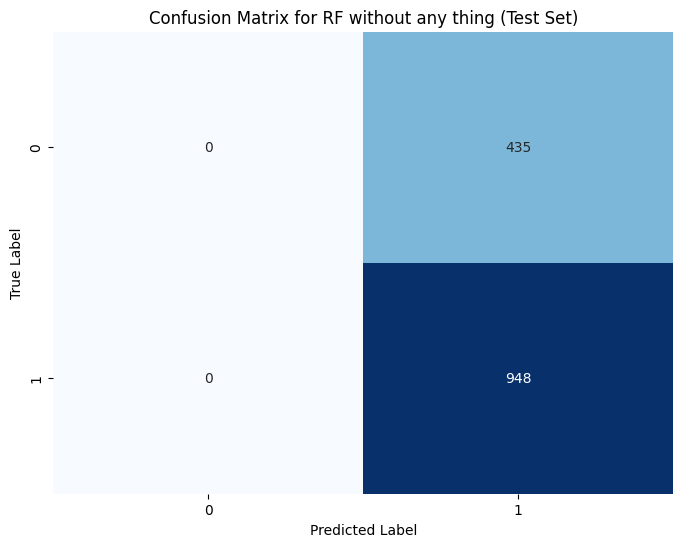

In [11]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for RF without any thing (Test Set)")
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# param_grid = {'n_estimators': [25, 50, 100, 150],
#               'max_depth': [3, 6, 9,11],
#               'max_leaf_nodes': [3, 6, 9,11]}


# Creating the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=11,max_leaf_nodes=6 )

# Training the model
rf_model.fit(re_Xtrain, y_train)

# Making predictions
y_pred = rf_model.predict(re_Xtest)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6992046276211136
Precision: 0.7909428057073429
Recall: 0.6992046276211136
F1 Score: 0.5884564693899409


True Positives: 948
True Negatives: 19
False Positives: 416
False Negatives: 0


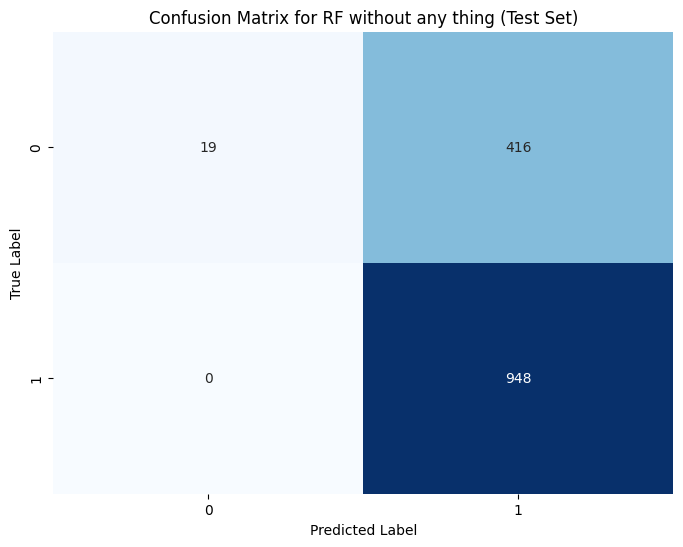

In [13]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for RF without any thing (Test Set)")
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# param_grid = {'n_estimators': [25, 50, 100, 150],
#               'max_depth': [3, 6, 9,11],
#               'max_leaf_nodes': [3, 6, 9,11]}


# Creating the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=11,max_leaf_nodes=11 )

# Training the model
rf_model.fit(re_Xtrain, y_train)

# Making predictions
y_pred = rf_model.predict(re_Xtest)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.5929139551699205
Precision: 0.4478744458175973
Recall: 0.5929139551699205
F1 Score: 0.5102881793019378


True Positives: 820
True Negatives: 0
False Positives: 435
False Negatives: 128


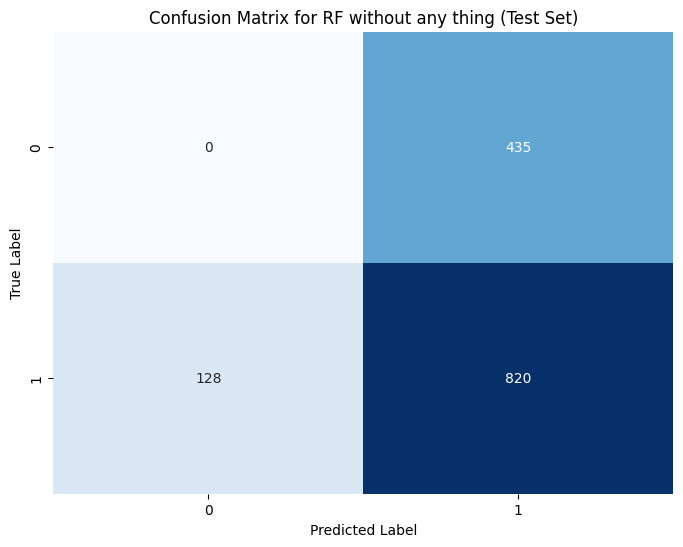

In [15]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for RF without any thing (Test Set)")
plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# param_grid = {'n_estimators': [25, 50, 100, 150],
#               'max_depth': [3, 6, 9,11],
#               'max_leaf_nodes': [3, 6, 9,11]}


# Creating the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=3,max_leaf_nodes=6 )

# Training the model
rf_model.fit(re_Xtrain, y_train)

# Making predictions
y_pred = rf_model.predict(re_Xtest)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.5885755603759942
Precision: 0.45849378361832865
Recall: 0.5885755603759942
F1 Score: 0.5125583764099846


True Positives: 809
True Negatives: 5
False Positives: 430
False Negatives: 139


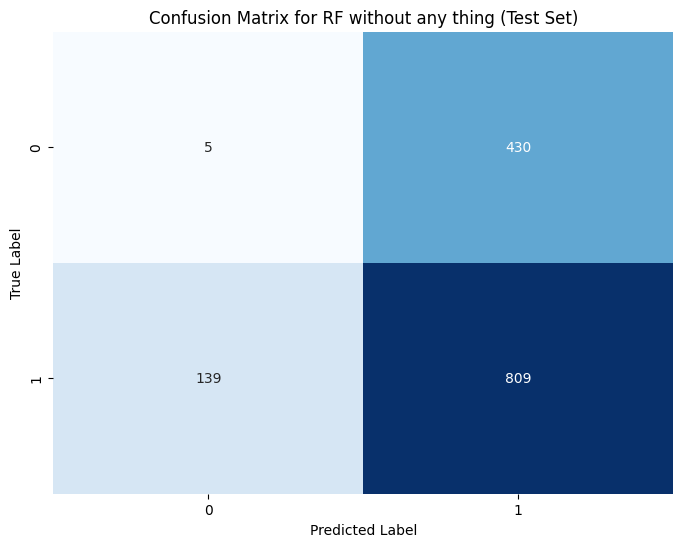

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for RF without any thing (Test Set)")
plt.show()

# **Grid search KNN**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

param_grid = {'n_neighbors': [3, 5, 7, 9,11,13,15],
              'weights':['uniform','distance'],
              'algorithm':['auto','ball_tree','kd_tree','brute']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, cv=5 ,verbose = 1 ,n_jobs=-1)

# fitting the model for grid search
grid.fit(re_Xtrain, y_train)

# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(re_Xtest)

# print classification report
print(classification_report(y_test, grid_predictions))


# Evaluate the final model on the test set
y_test_pred = grid_predictions
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print metrics for test set
print("Test Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1-score:", test_f1)


Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.44      0.29      0.35       580
           1       0.59      0.73      0.65       803

    accuracy                           0.55      1383
   macro avg       0.52      0.51      0.50      1383
weighted avg       0.53      0.55      0.53      1383

Test Set Metrics:
Accuracy: 0.5480838756326826
Precision: 0.5891783567134269
Recall: 0.7322540473225405
F1-score: 0.6529705719044975


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 588
True Negatives: 170
False Positives: 410
False Negatives: 215


# **DT+Grid**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, cv=5 ,verbose = 1 ,n_jobs=-1)

# fitting the model for grid search
grid.fit(re_Xtrain, y_train)

# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(re_Xtest)

# print classification report
print(classification_report(y_test, grid_predictions))


# Evaluate the final model on the test set
y_test_pred = grid_predictions
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Print metrics for test set
print("Test Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1-score:", test_f1)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       580
           1       0.84      0.99      0.91       803

    accuracy                           0.89      1383
   macro avg       0.92      0.87      0.88      1383
weighted avg       0.90      0.89      0.89      1383

Test Set Metrics:
Accuracy: 0.888647866955893
Precision: 0.8426610348468849
Recall: 0.9937733499377335
F1-score: 0.912


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 798
True Negatives: 431
False Positives: 149
False Negatives: 5


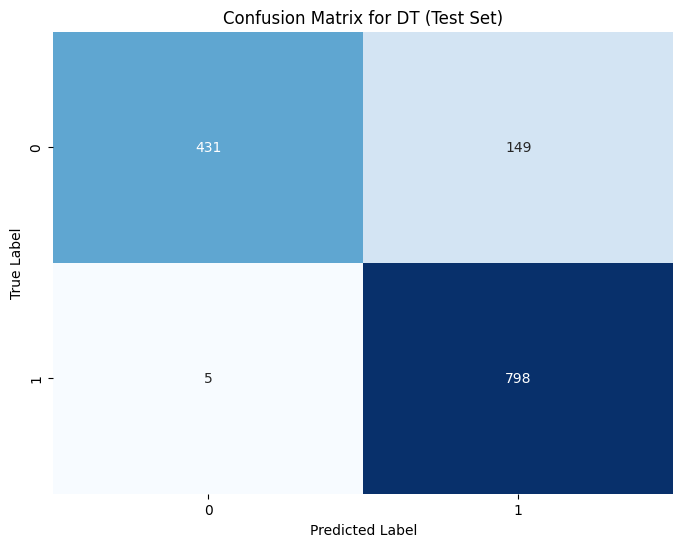

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for DT (Test Set)")
plt.show()

In [ ]:
import joblib

# Save the trained model and feature selection step
joblib.dump(grid, '/content/drive/MyDrive/GP-Trail/DT_Grid_model_best.pkl')


['/content/drive/MyDrive/GP-Trail/DT_Grid_model_best.pkl']

In [ ]:
import joblib

# Save the trained model and feature selection step
joblib.dump(grid.best_estimator_, '/content/drive/MyDrive/GP-Trail/DT_Grid_model_best2.pkl')


['/content/drive/MyDrive/GP-Trail/DT_Grid_model_best2.pkl']